In [1]:
import simulate
import withdrawal
import market
import harvesting
import metrics
from decimal import Decimal as D
import plot

import pandas
import numpy

/Users/justus/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
class CappedVPW(withdrawal.VPW):
    ceiling = 80000

    def _calc(self):
        amt = super()._calc()
        ceiling = self.ceiling * self.cumulative_inflation
        return min(amt, ceiling)

In [3]:
class SplitVPW(withdrawal.VPW):
    def __init__(self, portfolio, harvest_strategy, years_left=35):
        super().__init__(portfolio, harvest_strategy, years_left=years_left)
        self.initial_floor = D('.03') * D('.6') * self.portfolio.value
        
    def _calc(self):
        floor = self.initial_floor * self.cumulative_inflation
        rest_of_portfolio = self.portfolio.value * D('.4')
        
        rate = (self.portfolio.stocks_pct * self.stock_growth_rate
                + self.portfolio.bonds_pct * self.bond_growth_rate)

        amt = metrics.pmt(rate, self.years_left, rest_of_portfolio)        
        # max out at 20% of the current portfolio...this allows it to run
        # "indefinitely"
        vpw_amount = min(amt, rest_of_portfolio / 5)
        
        return floor + vpw_amount

In [4]:
def run_one(withdrawal_strategy=withdrawal.VPW):
    MARKET = market.Returns_US_1871()

    years = 30
    end_year = 2018 - years + 1
    series = pandas.Series(index=numpy.arange(MARKET.start_year, end_year))

    for start in range(MARKET.start_year, end_year):
        annual_data = simulate.withdrawals(MARKET.iter_from(start),
                                           years=years,
                                           harvesting=harvesting.N_60_RebalanceHarvesting,
                                           withdraw=withdrawal_strategy)
        min_wd = annual_data[0].withdraw_r
        for y in annual_data:
            min_wd = min(min_wd, y.withdraw_r)
        series.loc[start] = min_wd
    return series

#    u = metrics.ulcer([y.portfolio_r for y in annual_data])
#    series.loc[start] = u

/Users/justus/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


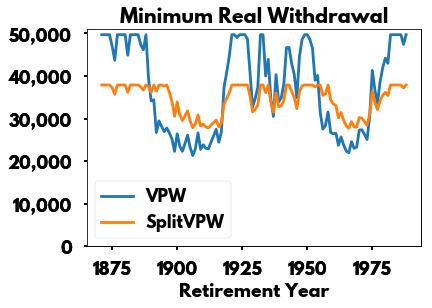

In [5]:
vpw = run_one()    
capped = run_one(CappedVPW)
split = run_one(SplitVPW)
#plot.plot_n({'VPW' : vpw, 'Capped' : capped}, 'Retirement Year', 'Minimum Real Withdrawal')
plot.plot_n({'VPW' : vpw, 'SplitVPW' : split}, 'Retirement Year', 'Minimum Real Withdrawal')

In [6]:
vpw.sort_values()

1906    21298.62390367568859936412483
1966    21944.36808480800814818665150
1899    22278.40847352900953793892699
1902    22291.82562795607994790985285
1965    22343.18297843646952083832774
1909    22747.05903537358506781056438
1912    22879.24031257596115850257896
1907    22931.60989725984826450611617
1968    22991.41276571903071553890420
1911    23005.69091616583299933177873
1905    23150.87193028591609562806220
1969    23259.67553171824938077833473
1901    23507.34082569700947018087809
1962    23722.34042542567144868425323
1964    23740.07553170589315578928164
1910    23829.12043593575831813681187
1903    24113.70840336809482223021808
1916    24429.59999894129760288332250
1913    24438.10526191591399793443769
1967    24540.94999970063236749746849
1973    25062.34042528564701722647112
1898    25150.99349429828253752876603
1963    25678.62127639627061472156005
1914    25902.10526196066101401398744
1904    26072.94712360146286263431657
1972    26274.26808486428019777855798
1960    2640

/Users/justus/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


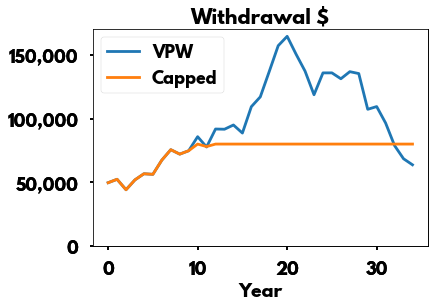

/Users/justus/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


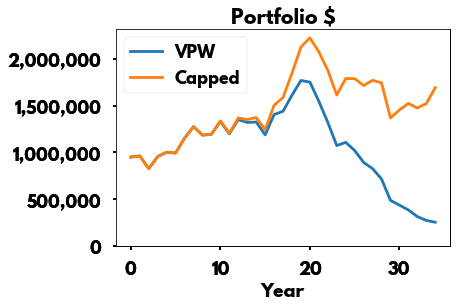

In [7]:
YEAR = 1980
MARKET = market.Returns_US_1871()
years = 35
vpw = simulate.withdrawals(MARKET.iter_from(YEAR),
                                           years=years,
                                           harvesting=harvesting.N_60_RebalanceHarvesting,
                                           withdraw=withdrawal.VPW)
capped = simulate.withdrawals(MARKET.iter_from(YEAR),
                                           years=years,
                                           harvesting=harvesting.N_60_RebalanceHarvesting,
                                           withdraw=CappedVPW)

plot.plot_n({
    'VPW' : [n.withdraw_r for n in vpw],
    'Capped' : [n.withdraw_r for n in capped]
}, 'Year', 'Withdrawal $')

plot.plot_n({
    'VPW' : [n.portfolio_r for n in vpw],
    'Capped' : [n.portfolio_r for n in capped]
}, 'Year', 'Portfolio $')

In [8]:
capped[34].portfolio_r

Decimal('1690416.647283264061423625218')

In [9]:
def run_cew(withdrawal_strategy=withdrawal.VPW):
    MARKET = market.Returns_US_1871()

    years = 30
    end_year = 2018 - years + 1
    series = pandas.Series(index=numpy.arange(MARKET.start_year, end_year))

    for start in range(MARKET.start_year, end_year):
        annual_data = simulate.withdrawals(MARKET.iter_from(start),
                                           years=years,
                                           harvesting=harvesting.N_60_RebalanceHarvesting,
                                           withdraw=withdrawal_strategy)
        cew = metrics.cew([n.withdraw_r for n in annual_data])
        series.loc[start] = cew
    return series

#    u = metrics.ulcer([y.portfolio_r for y in annual_data])
#    series.loc[start] = u

/Users/justus/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


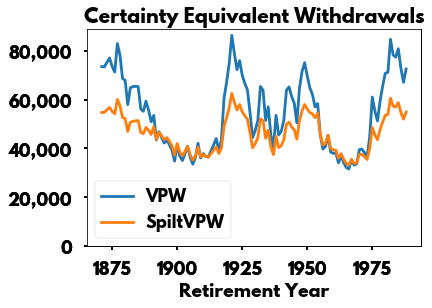

In [10]:
vpw = run_cew()
capped = run_cew(CappedVPW)
split = run_cew(SplitVPW)
#plot.plot_n({'VPW' : vpw, 'Capped' : capped}, 'Retirement Year', 'Certainty Equivalent Withdrawals')
plot.plot_n({'VPW' : vpw, 'SpiltVPW' : split}, 'Retirement Year', 'Certainty Equivalent Withdrawals')

In [11]:
def compare(year, other_withdrawal_strategy):
    YEAR = year
    MARKET = market.Returns_US_1871()
    years = 35
    vpw = simulate.withdrawals(MARKET.iter_from(YEAR),
                                               years=years,
                                               harvesting=harvesting.N_60_RebalanceHarvesting,
                                               withdraw=withdrawal.VPW)
    other = simulate.withdrawals(MARKET.iter_from(YEAR),
                                               years=years,
                                               harvesting=harvesting.N_60_RebalanceHarvesting,
                                               withdraw=other_withdrawal_strategy)

    plot.plot_n({
        'VPW' : [n.withdraw_r for n in vpw],
        other_withdrawal_strategy.__name__ : [n.withdraw_r for n in other]
    }, 'Year', 'Withdrawal $ for %s retiree' % year)

    plot.plot_n({
        'VPW' : [n.portfolio_r for n in vpw],
        other_withdrawal_strategy.__name__ : [n.portfolio_r for n in other]
    }, 'Year', 'Portfolio $ for %s retiree' % year)
    
    return (vpw, other)

/Users/justus/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


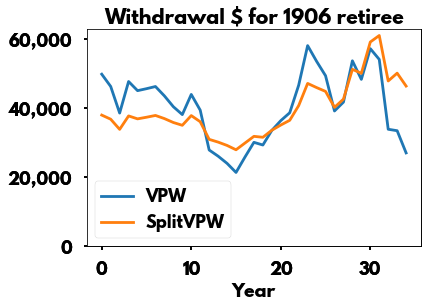

/Users/justus/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


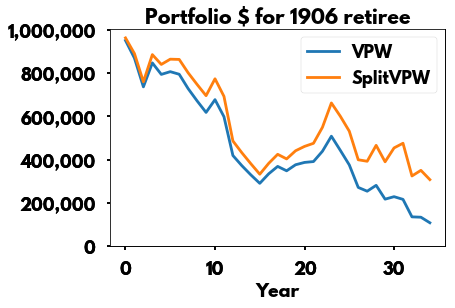

773133.2503428768662466019831
691954.2825190682548528466987
485735.7627540019077928255154
431367.0139283183676954093518
380833.1821792839453552882986
332281.8289690850735138805224
382550.8315151067500031892100
424141.1749372122980690861920
402956.8394031487385462180739
440568.3565296966490359052647
VPW      0.07342717233583791992381248483
Split    0.08382641741748667517877713004
Diff        6555.37139173275288011247601
Name: 15, dtype: object


In [12]:
results = compare(1906, SplitVPW)
def c(results):
    vpw, split = results
    vpw_wd = [n.withdraw_r for n in vpw]
    vpw_p = [n.portfolio_r for n in vpw]
    split_wd = [n.withdraw_r for n in split]
    split_p = [n.portfolio_r for n in split]
    
    diff = pandas.DataFrame(index=range(len(vpw_wd)), columns=['VPW', 'Split', 'Diff'])

    for i in range(len(vpw_wd)):
        diff.iloc[i] = (vpw_wd[i] / vpw_p[i], split_wd[i] / split_p[i], split_wd[i] - vpw_wd[i])
        
    #diff.to_csv('split-diff.csv')
    for i in range(10,20):
        print(split_p[i])
    
    print(diff.iloc[15])
    
c(results)

In [15]:
def check90(year):
    YEAR = year
    MARKET = market.Returns_US_1871()
    years = 35
    r = simulate.withdrawals(MARKET.iter_from(YEAR),
                                               years=years,
                                               harvesting=harvesting.N_60_RebalanceHarvesting,
                                               withdraw=withdrawal.ConstantDollar)
    series = pandas.Series([n.portfolio_r for n in r])
    under = series[series < 900000]
    pct = len(under) / len(series)
    
    return pct

In [22]:
pct_series = pandas.Series(index=range(1871, 2018-35+1))
for year in range(1871, 2018 - 35 + 1):
    pct_series.loc[year] = check90(year)

In [23]:
pct_series.sort_values()

1871    0.000000
1923    0.000000
1924    0.000000
1925    0.000000
1926    0.000000
1982    0.000000
1932    0.000000
1922    0.000000
1933    0.000000
1949    0.000000
1950    0.000000
1951    0.000000
1952    0.000000
1953    0.000000
1954    0.000000
1948    0.000000
1921    0.000000
1927    0.000000
1983    0.000000
1885    0.000000
1884    0.000000
1883    0.000000
1882    0.000000
1872    0.000000
1873    0.000000
1874    0.000000
1875    0.000000
1880    0.000000
1877    0.000000
1878    0.000000
          ...   
1917    0.714286
1963    0.742857
1901    0.742857
1903    0.742857
1939    0.771429
1905    0.800000
1962    0.800000
1964    0.828571
1929    0.857143
1907    0.857143
1914    0.857143
1910    0.885714
1967    0.885714
1970    0.885714
1909    0.885714
1965    0.914286
1971    0.914286
1899    0.914286
1911    0.942857
1913    0.942857
1968    0.942857
1972    0.942857
1966    0.942857
1902    0.942857
1969    0.971429
1906    0.971429
1912    0.971429
1937    0.9714